# 北京理工大学-2024研究生课程-数据挖掘-互评作业二: 频繁模式与关联规则挖掘
姓名：周永扬    学号：3220231274
## 1. 问题描述
本次作业中，将选择2个数据集进行分析与挖掘。
## 2. 数据集选择
选择的数据集为：
1. Microsoft 资讯推荐:  https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets
2. SNAP(Stanford Large Network Dataset Collection)中的github social network:https://snap.stanford.edu/data/github-social.html
## 3. 数据分析要求
数据获取与预处理；
频繁模式挖掘：可以是项集、序列和图。
模式命名：如论文-作者网络中合作模式、引用模式和发表模式等，不同的领域的频繁模式的含义也不尽相同，需自行确定模式的名称。
对挖掘结果进行分析；
可视化展示。

## 3.1 Microsoft 资讯推荐
首先依照数据网站给出的说明进行数据下载与读取。

In [1]:
# 数据下载与读取
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename


zip_path = download_url(training_small_url, destination_filename="../dataset/MINDsmall_train.zip", verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_train.zip


['behaviors.tsv', 'entity_embedding.vec', 'news.tsv', 'relation_embedding.vec']

## 3.1.2 数据预处理
下载数据完成后进行数据预处理。
根据数据集说明，该数据集下总共包含两个表，分别为behaviors.tsv,该表记录了印象日志以及用户的新闻历史点击记录。该表共有印象ID，用户ID，时间，历史记录以及映像五列。需要在read_table时进行指定。

In [2]:
# 读取behaviors.tsv
data_path = os.path.join(temp_dir, 'behaviors.tsv')
column_names = ['ID', 'userID', 'time', 'history', 'behavior']
mind_data = pd.read_table(data_path, names=column_names)

print("columns: {}".format(mind_data.columns))
print("shape: {}".format(mind_data.shape))
mind_data.head()


columns: Index(['ID', 'userID', 'time', 'history', 'behavior'], dtype='object')
shape: (156965, 5)


,ID,userID,time,history,behavior
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


下面进行数据预处理，需要进行的工作有3项：
1. 对包含Nan的数据进行丢弃。
2. 对于history列，需要将字符串拆分为列表，这是因为history的每一个条目对应一个新闻。
3. 对于behavior列，同样需要根据规则进行拆分，得到每一个新闻条目是否进行了点击。

In [3]:
# 查看Nan数据
Nan_count = mind_data.isna().any(axis=1).sum()
print("Nan count: {}".format(Nan_count))

mind_data = mind_data.dropna()
mind_data_new = mind_data.copy()

# 对history进行处理
mind_data_new['history'] = mind_data['history'].apply(lambda x: x.split())
# 对behavior进行处理
func = lambda x: (t.split('-') for t in x.split())
mind_data_new['behavior'] = mind_data['behavior'].apply(lambda x: [t.split('-') for t in x.split()])

mind_data_new.head()

Nan count: 3238


,ID,userID,time,history,behavior
0,1,U13740,11/11/2019 9:05:58 AM,"[N55189, N42782, N34694, N45794, N18445, N6330...","[[N55689, 1], [N35729, 0]]"
1,2,U91836,11/12/2019 6:11:30 PM,"[N31739, N6072, N63045, N23979, N35656, N43353...","[[N20678, 0], [N39317, 0], [N58114, 0], [N2049..."
2,3,U73700,11/14/2019 7:01:48 AM,"[N10732, N25792, N7563, N21087, N41087, N5445,...","[[N50014, 0], [N23877, 0], [N35389, 0], [N4971..."
3,4,U34670,11/11/2019 5:28:05 AM,"[N45729, N2203, N871, N53880, N41375, N43142, ...","[[N35729, 0], [N33632, 0], [N49685, 1], [N2758..."
4,5,U8125,11/12/2019 4:11:21 PM,"[N10078, N56514, N14904, N33740]","[[N39985, 0], [N36050, 0], [N16096, 0], [N8400..."


## 3.1.3 频繁模式挖掘
在完成数据预处理后可以进行频繁模式挖掘。
在这一步，我们首先以history作为事务数据，使用apriori算法寻找频繁项集，阈值分别设置为0.02，0.03，0.04。

In [4]:
# 提取历史记录作为事务数据
transactions = list(mind_data_new['history'])

# 使用 TransactionEncoder 转换数据
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# 使用 apriori 算法找到频繁项集，设置最小支持度阈值
frequent_itemsets_002 = apriori(df, min_support=0.02, use_colnames=True)
frequent_itemsets_003 = apriori(df, min_support=0.03, use_colnames=True)
frequent_itemsets_004 = apriori(df, min_support=0.04, use_colnames=True)

In [5]:
# 查看频繁项集
print("threhold == 0.02 : {}".format(frequent_itemsets_002))
print("threhold == 0.03 : {}".format(frequent_itemsets_003))
print("threhold == 0.04 : {}".format(frequent_itemsets_004))


threhold == 0.02 :       support          itemsets
0    0.046934          (N10059)
1    0.020094          (N10235)
2    0.022039          (N10470)
3    0.020517          (N10559)
4    0.027685          (N10865)
..        ...               ...
213  0.023438    (N45794, N306)
214  0.021187    (N306, N55189)
215  0.027445      (N306, N871)
216  0.020023  (N45794, N31801)
217  0.021284  (N45794, N59704)

[218 rows x 2 columns]
threhold == 0.03 :      support  itemsets
0   0.046934  (N10059)
1   0.031478  (N10897)
2   0.036448  (N11005)
3   0.037866  (N11101)
4   0.035192  (N11231)
..       ...       ...
92  0.035635  (N64467)
93  0.049224   (N8148)
94  0.044631   (N8448)
95  0.087174    (N871)
96  0.030242   (N9803)

[97 rows x 2 columns]
threhold == 0.04 :      support  itemsets
0   0.046934  (N10059)
1   0.056561   (N1150)
2   0.043616  (N12349)
3   0.040188  (N12907)
4   0.040904  (N13137)
5   0.051052  (N13138)
6   0.048339  (N14761)
7   0.042400  (N15676)
8   0.053641  (N16233)
9   0.

在设定阈值分别为0.02，0.03，0.04下，得到的频繁项集分别有218条，97条以及57条。其中以0.02为阈值的情况下，包含2次项集，其余均为1次项集。
下面提取behavior的频繁项集，我们分别统计被点击和未被点击的部分。

In [6]:
# 统计被点击和未被点击的behavior
click_behavior = [
    [item[0] for item in behavior if item[1] == '1']
    for behavior in mind_data_new['behavior']
]
unclick_behavior = [
    [item[0] for item in behavior if item[1] == '0']
    for behavior in mind_data_new['behavior']
]


下面将分别进行频繁项集计算。由于点击项比较分散，采用0.005作为阈值，为点击项比较集中，采用0.1作为阈值。

In [7]:
# click的频繁项集
transactions_click = click_behavior
te = TransactionEncoder()
te_ary = te.fit(transactions_click).transform(transactions_click)
df = pd.DataFrame(te_ary, columns=te.columns_)

# # 使用 apriori 算法找到频繁项集，设置最小支持度阈值

click_items = apriori(df, min_support=0.005, use_colnames=True)


In [8]:
click_items

,support,itemsets
0,0.005510,(N1034)
1,0.005191,(N14029)
2,0.005601,(N19661)
3,0.005581,(N23414)
4,0.012282,(N23446)
5,0.007195,(N26262)
6,0.013491,(N287)
7,0.020693,(N33619)
8,0.006668,(N33885)
9,0.005367,(N34185)


In [9]:
# unclick的频繁项集
transactions_click = unclick_behavior
te = TransactionEncoder()
te_ary = te.fit(transactions_click).transform(transactions_click)
df = pd.DataFrame(te_ary, columns=te.columns_)

# # 使用 apriori 算法找到频繁项集，设置最小支持度阈值

unclick_items = apriori(df, min_support=0.05, use_colnames=True)

In [10]:
unclick_items

,support,itemsets
0,0.072538,(N10960)
1,0.079817,(N11817)
2,0.068114,(N11830)
3,0.099508,(N13907)
4,0.057706,(N14029)
...,...,...
198,0.053354,"(N62360, N32544, N41020)"
199,0.053094,"(N62360, N32544, N49180)"
200,0.056952,"(N59673, N34876, N47061)"
201,0.057140,"(N36226, N50872, N38779)"


## 3.1.3 关联规则
下面从未点击的频繁项集计算关联规则



In [95]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(unclick_items, metric="confidence", min_threshold=0.3)
print("\nAssociation Rules:")
rules


Association Rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(N23446),(N10960),0.086010,0.072538,0.052860,0.614582,8.472586,0.046621,2.406379,0.964969
1,(N10960),(N23446),0.072538,0.086010,0.052860,0.728724,8.472586,0.046621,3.369225,0.950952
2,(N36226),(N10960),0.077267,0.072538,0.056106,0.726132,10.010416,0.050501,3.386535,0.975476
3,(N10960),(N36226),0.072538,0.077267,0.056106,0.773473,10.010416,0.050501,4.073396,0.970502
4,(N38779),(N10960),0.105297,0.072538,0.052704,0.500525,6.900208,0.045066,1.856875,0.955710
...,...,...,...,...,...,...,...,...,...,...
251,"(N62360, N41020)",(N49180),0.066930,0.094726,0.058773,0.878122,9.270094,0.052433,7.427720,0.956120
252,"(N49180, N41020)",(N62360),0.077078,0.097010,0.058773,0.762512,7.860164,0.051296,3.802250,0.945666
253,(N62360),"(N49180, N41020)",0.097010,0.077078,0.058773,0.605847,7.860164,0.051296,2.341533,0.966540
254,(N49180),"(N62360, N41020)",0.094726,0.066930,0.058773,0.620450,9.270094,0.052433,2.458361,0.985477


下面对关联规则进行评价。

In [96]:
# 计算提升度
rules['lift'] = rules['lift'].apply(lambda x: round(x, 2))

# 进行卡方检验
observed = rules['support'] * len(df)  # 观察到的频数
expected = rules['antecedent support'] * rules['consequent support'] * len(df)  # 期望频数
chi_squared = ((observed - expected) ** 2 / expected).sum()  # 计算卡方值

# 输出结果
print("关联规则提升度:")
print(rules[['antecedents', 'consequents', 'lift']])
print("\n卡方检验结果:")
print("卡方值:", chi_squared)

关联规则提升度:
          antecedents       consequents   lift
0            (N23446)          (N10960)   8.47
1            (N10960)          (N23446)   8.47
2            (N36226)          (N10960)  10.01
3            (N10960)          (N36226)  10.01
4            (N38779)          (N10960)   6.90
..                ...               ...    ...
251  (N62360, N41020)          (N49180)   9.27
252  (N49180, N41020)          (N62360)   7.86
253          (N62360)  (N49180, N41020)   7.86
254          (N49180)  (N62360, N41020)   9.27
255          (N41020)  (N62360, N49180)   9.13

[256 rows x 3 columns]

卡方检验结果:
卡方值: 14751176.80647311


下面找出一部分强关联规则,将提升度大于11.0，置信度大于0.9的规则认为是强关联规则。

In [97]:
# strong_rules = rules[(rules['lift'] > 9.0 and rules['confidence'] > 0.7)]
indices =  (rules['lift'] > 11) & (rules['confidence'] > 0.9)
strong_rules = rules[indices]
strong_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
26,(N154),(N42961),0.055286,0.073370,0.051266,0.927286,12.64,0.047210,12.743407,0.974768
30,(N62386),(N16096),0.067965,0.076259,0.062292,0.916539,12.02,0.057109,11.067948,0.983651
173,"(N59673, N13907)",(N34876),0.058890,0.074496,0.053810,0.913730,12.27,0.049423,10.728029,0.975944
196,"(N62386, N3344)",(N16096),0.055046,0.076259,0.051845,0.941858,12.35,0.047647,15.887602,0.972570
198,"(N3344, N16096)",(N62386),0.055111,0.067965,0.051845,0.940746,13.84,0.048100,15.729489,0.981866


## 3.1.4 模式命名以及分析
下面进行模式命名。
1. 对于(N154)->(N42961)以及(N62386)->(N16096)，命名为无效推荐模式。这类新闻存在的共性使得新闻不容易被推荐以及用户点击。可以挖掘这类新闻在排版、内容、标题、题材上的共性。
2. 对于后三个规则，命名为未点击模式。这类新闻完全不会被点击，说明在具体的内容设置上存在问题，可以改进。

对于推荐新闻而言，应该寻找在不容易被点击新闻中的共性，排除这些导致点击量较低的原因，再在具体的领域进行修改、调整。这类完全不被点击的新闻可能存在严重的基本错误，即从标题、领域开始就难以吸引读者的注意力。

## 3.1.5 可视化
下面进行数据的可视化。
首先通过柱状图展示常见的新闻页面以及对应的频次。
其次通过柱状图可视化关联规则的support值。

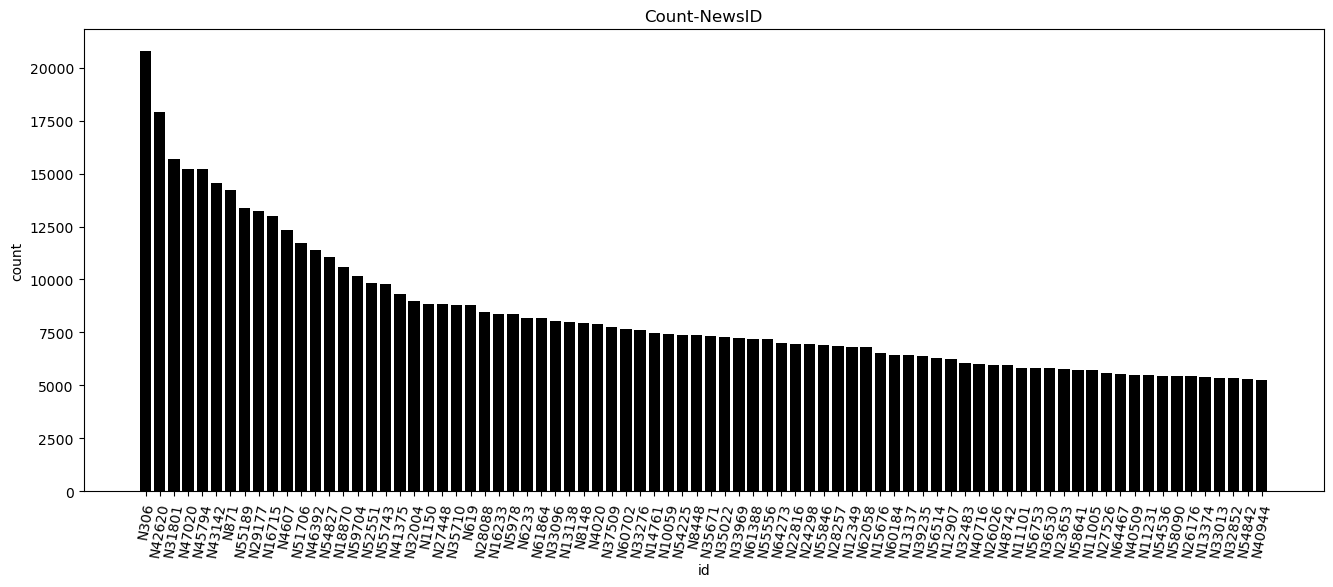

In [98]:
from collections import Counter
import matplotlib.pyplot as plt
all_news = [news_id for sublist in mind_data_new['history'] for news_id in sublist]
news_frequency = Counter(all_news)
# 将频率数据转换为DataFrame进行排序和可视化
news_freq_df = pd.DataFrame(news_frequency.items(), columns=['id', 'count'])
news_freq_df = news_freq_df.sort_values(by='count', ascending=False)



# 可视化最常被点击的新闻ID
plt.figure(figsize=(16, 6))
plt.bar(news_freq_df['id'].head(80), news_freq_df['count'].head(80), color='black')
plt.xlabel('id')
plt.ylabel('count')
plt.title('Count-NewsID')
plt.xticks(rotation=80)
plt.show()

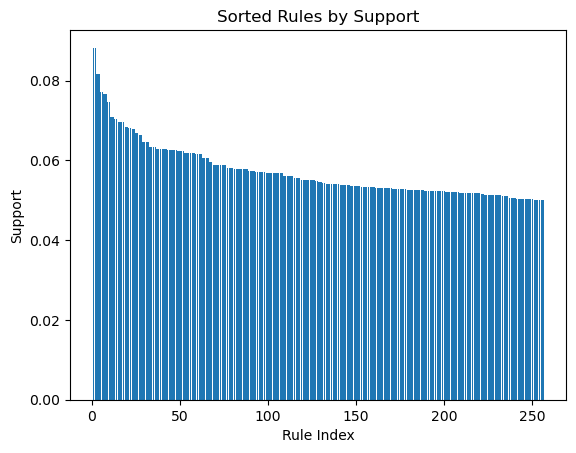

In [112]:

# 按support大小对strong_rules进行排序
sorted_rules = rules.sort_values(by='support', ascending=False)

# 打印排序后的结果
# print(sorted_rules)
supports = sorted_rules['support']
indices = list(range(1, len(supports) + 1))

# 绘制柱状图
plt.bar(indices, supports)

# 设置坐标轴标签和图表标题
plt.xlabel('Rule Index')
plt.ylabel('Support')
plt.title('Sorted Rules by Support')

# 显示图表
plt.show()

## 3.2 SNAP:Github Social Network
第二个数据集采用SNAP的Github Social Network数据集。该数据集包含musae_git_edges.csv数据，该数据为一个无向图数据,包含所有的边，id_1, id_2代表两个id所代表的github用户存在共同合作。下面首先导入数据并创建无向图
### 3.2.1 数据读取与预处理

In [10]:
import pandas as pd
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# 读取图数据
df = pd.read_csv("../dataset/git_web_ml/musae_git_edges.csv")

# 创建无向图
G = nx.Graph()

# 添加边到无向图中
for index, row in df.iterrows():
    node1 = row['id_1']
    node2 = row['id_2']
    G.add_edge(node1, node2)

下面查看生成的无向图的基本数据，包括节点数目，边数目，平均度数，最大度，最小度。

In [14]:
# 查看节点数和边数
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"节点数: {num_nodes}")
print(f"边数: {num_edges}")

# 查看最大度和最小度
node_degrees = dict(G.degree(G.nodes()))
max_degree = max(node_degrees.values())
min_degree = min(node_degrees.values())

print(f"最大度: {max_degree}")
print(f"最小度: {min_degree}")


节点数: 37700
边数: 289003
最大度: 9458
最小度: 1


### 3.2.2 频繁模式挖掘
下一步进行频繁模式挖掘。首先提取每个节点相连的节点，并进行列表化。

In [15]:
# 对每个ID记录它哪些被跟随的ID
coopers = {}
for node in G.nodes():
    coopers[node] = list(G.neighbors(node))

coopers[1]

[34526, 2370, 14683, 29982, 21142, 20363, 23830, 34035]

之后对这一列表进行频繁模式挖掘，采用apriori算法，最小支持度设置为0.01

In [20]:
# 将数据转换为适合频繁模式挖掘的格式
te = TransactionEncoder()
data = [coopers[node] for node in coopers]
te_ary = te.fit_transform(data)
transactions = pd.DataFrame(te_ary, columns=te.columns_)
# 应用Apriori算法进行频繁模式挖掘
frequent_itemsets = apriori(transactions, min_support=0.01, use_colnames=True)
frequent_itemsets


,support,itemsets
0,0.033607,(73)
1,0.016101,(974)
2,0.010027,(1164)
3,0.036286,(2078)
4,0.012971,(2281)
...,...,...
171,0.012095,"(31890, 35773, 19222)"
172,0.010955,"(27803, 36652, 19253)"
173,0.018170,"(31890, 27803, 35773)"
174,0.014138,"(31890, 27803, 36652)"


### 3.2.3 关联规则生成以及模式命名分析
下一步根据频繁模式生成关联规则。

In [22]:

# 生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(2078),(31890),0.036286,0.250875,0.020186,0.556287,2.217382,0.011082,1.688307,0.569690
1,(3153),(31890),0.019576,0.250875,0.012440,0.635501,2.533136,0.007529,2.055219,0.617317
2,(3712),(31890),0.033528,0.250875,0.022095,0.659019,2.626878,0.013684,2.196969,0.640805
3,(3922),(31890),0.018143,0.250875,0.010053,0.554094,2.208641,0.005501,1.680004,0.557345
4,(7027),(31890),0.039390,0.250875,0.023554,0.597980,2.383574,0.013672,1.863401,0.604264
5,(7027),(35773),0.039390,0.088170,0.020398,0.517845,5.873273,0.016925,1.891156,0.863761
6,(10080),(27803),0.014801,0.187931,0.010849,0.732975,3.900233,0.008067,3.041171,0.754777
7,(10080),(36652),0.014801,0.062149,0.012069,0.815412,13.120375,0.011149,5.080788,0.937661
8,(10595),(31890),0.026950,0.250875,0.020955,0.777559,3.099384,0.014194,3.367746,0.696115
9,(36289),(10595),0.015623,0.026950,0.010743,0.687606,25.514518,0.010322,3.114819,0.976056


之后对规则进行命名，由于我们挖掘了每个用户合作的其他用户的频繁模式。对于以上规则，可以产生以下模式：
1. 合作模式
    对于两个满足频繁模式的用户，可以认为他们常常在一个项目中合作。
2. 中心开发者模式
    对于那些与多个开发者相关的用户，可以认为它们是中心开发者，例如37、38、39、42、45、48都出现的31890号开发者总是与不同的开发者共同出现，可以认为它参与到了多个项目中，与很多人都有合作。
3. 领导模式
    对于那些常常伴随某个开发者出现的用户，可以认为满足领导模式，即某个或某些开发者，常常领导其他开发者参与到项目中。

对于以上挖掘结果来看，重要的开发者是指那些参与到大量项目中，与其他开发者具有较多合作的用户。同时重要开发者的合作者，也很可能是重要的开发者。
下面对关联规则进行评价。

In [28]:
# 计算提升度
rules['lift'] = rules['lift'].apply(lambda x: round(x, 2))

# 进行卡方检验
observed = rules['support'] * len(df)  # 观察到的频数
expected = rules['antecedent support'] * rules['consequent support'] * len(df)  # 期望频数
chi_squared = ((observed - expected) ** 2 / expected).sum()  # 计算卡方值

# 输出结果
print("关联规则提升度:")
print(rules[['antecedents', 'consequents', 'lift']])
print("\n卡方检验结果:")
print("卡方值:", chi_squared)

关联规则提升度:
       antecedents consequents   lift
0           (2078)     (31890)   2.22
1           (3153)     (31890)   2.53
2           (3712)     (31890)   2.63
3           (3922)     (31890)   2.21
4           (7027)     (31890)   2.38
5           (7027)     (35773)   5.87
6          (10080)     (27803)   3.90
7          (10080)     (36652)  13.12
8          (10595)     (31890)   3.10
9          (36289)     (10595)  25.51
10         (10830)     (31890)   2.64
11         (11279)     (31890)   2.85
12         (19253)     (27803)   2.99
13         (21142)     (31890)   2.97
14         (22353)     (31890)   2.28
15         (22642)     (31890)   2.55
16         (22666)     (31890)   2.55
17         (22881)     (27803)   2.75
18         (23589)     (31890)   2.41
19         (25477)     (27803)   2.82
20         (30002)     (27803)   2.81
21         (29982)     (31890)   3.15
22         (30002)     (31890)   2.35
23         (30199)     (31890)   2.40
24         (33029)     (31890)   2.18
25 

In [30]:
# 找出强关联规则
indices =  (rules['lift'] > 7) & (rules['confidence'] > 0.5)
strong_rules = rules[indices]
strong_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
7,(10080),(36652),0.014801,0.062149,0.012069,0.815412,13.12,0.011149,5.080788,0.937661
9,(36289),(10595),0.015623,0.026950,0.010743,0.687606,25.51,0.010322,3.114819,0.976056
34,"(31890, 7027)",(35773),0.023554,0.088170,0.014642,0.621622,7.05,0.012565,2.409837,0.878863
43,"(27803, 19253)",(36652),0.020928,0.062149,0.010955,0.523447,8.42,0.009654,1.967991,0.900109


### 3.2.5 可视化与分析
首先可视化与他人合作最多的100位开发者。

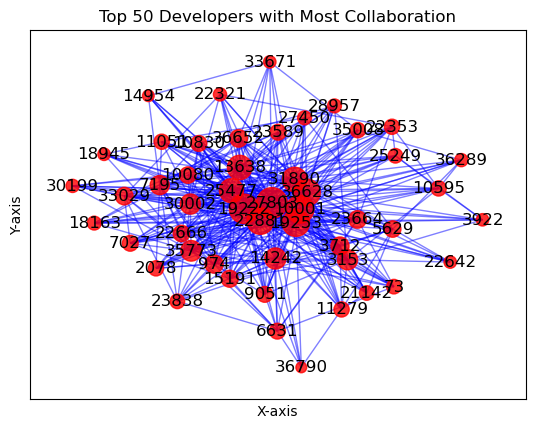

In [26]:
# 计算每个节点的度
node_degrees = dict(G.degree(G.nodes()))
# 找到与他人合作最多的50位开发者
top_50_developers = sorted(node_degrees, key=node_degrees.get, reverse=True)[:50]

# 创建子图
subgraph = G.subgraph(top_50_developers)

# 计算子图中节点的度
subgraph_node_degrees = dict(subgraph.degree(subgraph.nodes()))
# 绘制子图
pos = nx.spring_layout(subgraph)
nx.draw_networkx_nodes(subgraph, pos, node_size=[v * 10 for v in subgraph_node_degrees.values()], node_color='r', alpha=0.8)
nx.draw_networkx_edges(subgraph, pos, edge_color='b', alpha=0.5)
nx.draw_networkx_labels(subgraph, pos, font_size=12)

# 添加标题和坐标轴标签
plt.title("Top 50 Developers with Most Collaboration")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# 显示图形
plt.show()

以柱状图展示他们的合作者数量。

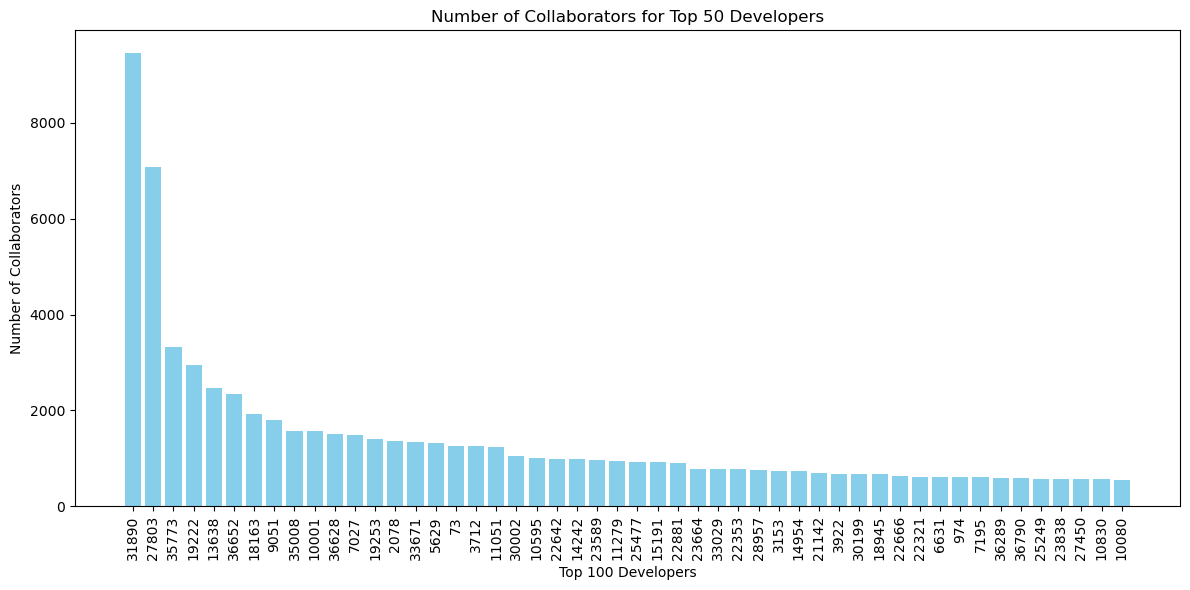

In [27]:
# 获取合作者数量
collaborator_counts = [node_degrees[developer] for developer in top_50_developers]

# 创建柱状图
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_50_developers)), collaborator_counts, color='skyblue')
plt.xlabel('Top 100 Developers')
plt.ylabel('Number of Collaborators')
plt.title('Number of Collaborators for Top 50 Developers')
plt.xticks(ticks=range(len(top_50_developers)), labels=top_50_developers, rotation=90)
plt.tight_layout()

# 显示柱状图
plt.show()